<a href="https://colab.research.google.com/github/AlsoSprachZarathushtra/Quick-Draw-Recognition/blob/master/(1_2)LastImg_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy
from tensorflow.keras.callbacks import CSVLogger
from ast import literal_eval


# Parameters  and  Work-Space Paths

In [0]:
# parameters
BATCH_SIZE = 200
EPOCHS = 50
STEPS_PER_EPOCH = 850
VALIDATION_STEPS = 100
EVALUATE_STEPS = 850
IMAGE_SIZE = 128
LINE_SIZE = 3


# load path
TRAIN_DATA_PATH = 'gdrive/My Drive/QW/Data/Data_10000/All_classes_10000.csv'
VALID_DATA_PATH = 'gdrive/My Drive/QW/Data/My_test_data/My_test_data.csv'
LABEL_DICT_PATH = 'gdrive/My Drive/QW/Data/labels_dict.npy'

# save path
CKPT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(1-2)LastImg_MobileNet/best_model_1_2.ckpt'
LOSS_PLOT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(1-2)LastImg_MobileNet/loss_plot_1_2.png'
ACC_PLOT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(1-2)LastImg_MobileNet/acc_plot_1_2.png'
LOG_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(1-2)LastImg_MobileNet/Log_1_2.log'
print('finish!')

finish!


# Generator

In [0]:
def generate_data(data, batch_size, choose_recognized):
    data = data.sample(frac = 1)
    while 1:
        
#         get columns' values named 'drawing', 'word' and 'recognized'
        drawings = data["drawing"].values
        drawing_recognized = data["recognized"].values
        drawing_class = data["word"].values
      
#         initialization
        cnt = 0
        data_X =[]
        data_Y =[]
        
#         generate batch
        for i in range(len(drawings)):
            if choose_recognized:
                if drawing_recognized[i] == 'False':    #Choose according to recognized value
                    continue
            draw = drawings[i]
            label = drawing_class[i]
            stroke_vec = literal_eval(draw)
            img = np.zeros([256, 256])
            for j in range(len(stroke_vec)): 
                line = np.array(stroke_vec[j]).T
                cv2.polylines(img, [line], False, 1, LINE_SIZE)
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_NEAREST)
            img = img[:,:, np.newaxis]
            x = img
            y = labels2nums_dict[label]
            data_X.append(x)
            data_Y.append(y)
            cnt += 1
            if cnt==batch_size:        #generate a batch when cnt reaches batch_size 
                cnt = 0
                yield (np.array(data_X), np.array(data_Y))
                data_X = []
                data_Y = []

print('finish!')

finish!


# Callbacks

In [0]:
# define a class named LossHitory 
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type, loss_fig_save_path, acc_fig_save_path):
        iters = range(len(self.losses[loss_type]))
        plt.figure('acc')
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc')
        plt.legend(loc="upper right")
        plt.savefig(acc_fig_save_path)
        plt.show()
        
        
        plt.figure('loss')
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.savefig(loss_fig_save_path)
        plt.show()
        
# create a object from LossHistory class
History = LossHistory()

print("finish!")

finish!


In [0]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    CKPT_PATH, 
    verbose = 1, 
    monitor='val_acc', 
    mode = 'max', 
    save_best_only=True)

print("finish!")

finish!


In [0]:
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)

In [0]:
csv_logger = CSVLogger(LOG_PATH, separator=',', append=True)

# Load Data

In [0]:
# load train data and valid data
#  labels_dict and data path

# labels convert into nums
labels_dict = np.load(LABEL_DICT_PATH)
labels2nums_dict = {v: k for k, v in enumerate(labels_dict)}

# read csv 
train_data = pd.read_csv(TRAIN_DATA_PATH)
valid_data = pd.read_csv(VALID_DATA_PATH)

print('finish!')

finish!


# Model

In [0]:

MODEL = tf.keras.applications.MobileNet(
        input_shape=(IMAGE_SIZE,IMAGE_SIZE,1),
        alpha=1.0,
        include_top=True,
        weights=None,
        classes=340
        )

MODEL.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

# Complie

In [0]:
model = MODEL
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('finish')

finish


# Train

start training
Epoch 1/50
849/850 [============================>.] - ETA: 0s - loss: 3.2709 - acc: 0.2955
Epoch 00001: val_acc improved from -inf to 0.32985, saving model to gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(1-2)LastImg_MobileNet/best_model_1_2.ckpt
850/850 [==============================] - 540s 635ms/step - loss: 3.2695 - acc: 0.2957 - val_loss: 3.0095 - val_acc: 0.3299
Epoch 2/50
849/850 [============================>.] - ETA: 0s - loss: 1.8670 - acc: 0.5488
Epoch 00002: val_acc improved from 0.32985 to 0.52070, saving model to gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/(1-2)LastImg_MobileNet/best_model_1_2.ckpt
850/850 [==============================] - 523s 616ms/step - loss: 1.8669 - acc: 0.5488 - val_loss: 2.0488 - val_acc: 0.5207
Epoch 3/50
849/850 [============================>.] - ETA: 0s - loss: 1.5905 - acc: 0.6088
Epoch 00003: val_acc improved from 0.52070 to 0.56900, saving model to gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pr

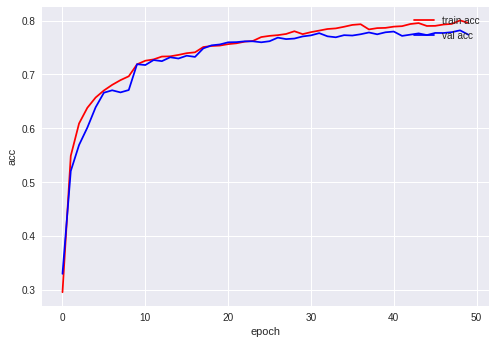

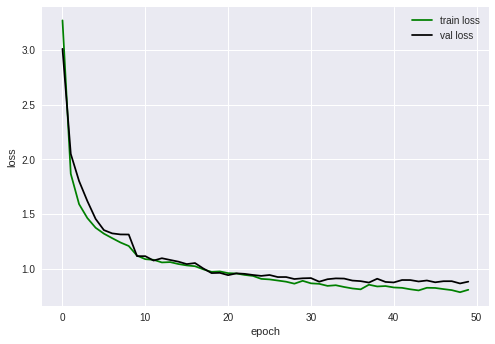

finish!


In [0]:
print('start training')
# callbacks = [History, cp_callback]

history = model.fit_generator(generate_data(train_data, BATCH_SIZE, True),
                              steps_per_epoch = STEPS_PER_EPOCH,
                              epochs = EPOCHS,
                              validation_data = generate_data(valid_data, BATCH_SIZE, False) ,
                              validation_steps = VALIDATION_STEPS,
                              verbose = 1,
                              initial_epoch = 0,
                              callbacks = [History,cp_callback,ReduceLR, csv_logger]
                             )
print("finish training")

History.loss_plot('epoch', LOSS_PLOT_PATH, ACC_PLOT_PATH)

print('finish!')

# Evaluate

In [0]:
def top_3_accuracy(X, Y):
        return sparse_top_k_categorical_accuracy(X, Y, 3)
  
def top_5_accuracy(X, Y):
        return sparse_top_k_categorical_accuracy(X, Y, 5)
  
model_E = MODEL
model_E.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',top_3_accuracy, top_5_accuracy])

model_weights_path = CKPT_PATH  
model_E.load_weights(model_weights_path)
print('finish')

finish


In [0]:
result = model_E.evaluate_generator(
    generate_data(valid_data, BATCH_SIZE, False),
    steps = EVALUATE_STEPS,
    verbose = 1
)
print('number of test samples:', len(result))
print('loss:', result[0])
print('top1 accuracy:', result[1])
print('top3 accuracy:', result[2])
print('top3 accuracy:', result[3])

850/850 [==============================] - 150s 176ms/step
number of test samples: 4
loss: 0.8837472029994515
top1 accuracy: 0.7758647046369664
top3 accuracy: 0.9089058828353882
top3 accuracy: 0.9344470597014708
